In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import numpy as np
import physics as phys
import utilities as utils
import spectrum
import transferfunction as tf
import matplotlib
import matplotlib.pyplot as plt
import pickle

matplotlib.rcParams['figure.figsize'] = [10,10]


from scipy import integrate
from astropy.io import fits
from tqdm import tqdm

In [3]:
transfer_func_table = pickle.load(open(
    "/Users/hongwan/Dropbox (MIT)/Photon Deposition/transfer_func_table.raw", "rb")
)

In [4]:
eng = np.array([transfer_func.in_eng 
                for transfer_func in transfer_func_table])
tf_rs_arr = np.array([spec.rs for spec in transfer_func_table[0]])

In [5]:
# Transfer function is normalized to 1 particle in the bin.
# To use the transfer function on dN/dE, need to further normalize.
norm_spec = spectrum.rebin_N_arr(np.ones(eng.size), eng, eng)

In [6]:
#Initialize
mwimp = eng[299]
print(mwimp)

rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[20]), 
                           -0.002)
                )

# Initial injection is 2 photons, to match up with what we have in file.
photon_spec_init = spectrum.rebin_N_arr(np.array([2]), 
                                        np.array([mwimp]), 
                                        eng)
                                       
photon_spec_init.rs = rs_list[0]

1060819228.18


In [7]:
photon_spectra = spectrum.Spectra([photon_spec_init])
append = photon_spectra.append

# List of transfer functions interpolated at rs_list, indexed by injection energy.
# Perform the normalization properly. 
tf_at_rs_list = [transfer_func.at_rs(rs_list)/norm_spec.dNdE[i]
                 for i,transfer_func in 
                 zip(np.arange(norm_spec.length), tqdm(transfer_func_table))]


100%|█████████▉| 499/500 [01:20<00:00,  5.45it/s]

In [8]:
for i in tqdm(np.arange(rs_list.size-1).astype(int)):
    tf_at_rs = spectrum.Spectra([transfer_func[i]
                             for transfer_func in tf_at_rs_list])
    append(tf_at_rs.sum_specs_by_weight(photon_spectra[-1]))
    photon_spectra[-1].rs = rs_list[i+1]



100%|██████████| 409/409 [00:10<00:00, 49.37it/s]


In [9]:
file = fits.open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits")

file_eng = file[1].data['energy'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]

In [10]:
file_spectra = spectrum.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)], 
                   rebin_eng = eng)

In [11]:
utils.compare_arr([eng,file_spectra[30].dNdE])

[[  3.07055574e+03   1.13102457e-02]
 [  3.21164413e+03   1.05478543e-02]
 [  3.35924860e+03   1.25761791e-02]
 [  3.51367319e+03   1.11827894e-02]
 [  3.67523644e+03   4.75553642e-03]
 [  3.67612926e+03   1.22689558e-02]
 [  3.84524889e+03   7.91294849e-03]
 [  4.02219842e+03   9.40702505e-03]
 [  4.20734499e+03   8.35482759e-03]
 [  4.40107337e+03   6.34710665e-03]
 [  4.60378687e+03   5.91139638e-03]
 [  4.81590825e+03   7.01140684e-03]
 [  5.03788072e+03   6.21572737e-03]
 [  5.27016899e+03   4.72633619e-03]
 [  5.51326034e+03   4.39906082e-03]
 [  5.76766581e+03   5.17072799e-03]
 [  6.03392139e+03   4.63745941e-03]
 [  6.31258935e+03   3.50609189e-03]
 [  6.60425955e+03   3.26113649e-03]
 [  6.90955095e+03   3.76782237e-03]
 [  7.22911308e+03   3.47315248e-03]
 [  7.56362767e+03   2.59056635e-03]
 [  7.91381037e+03   2.40780721e-03]
 [  8.28041253e+03   5.34901988e-03]
 [  8.28510892e+03   0.00000000e+00]
 [  8.66936069e+03   2.64922101e-03]
 [  9.07169094e+03   1.90460227e-03]
 

0

30.8762476697
30.8762476697


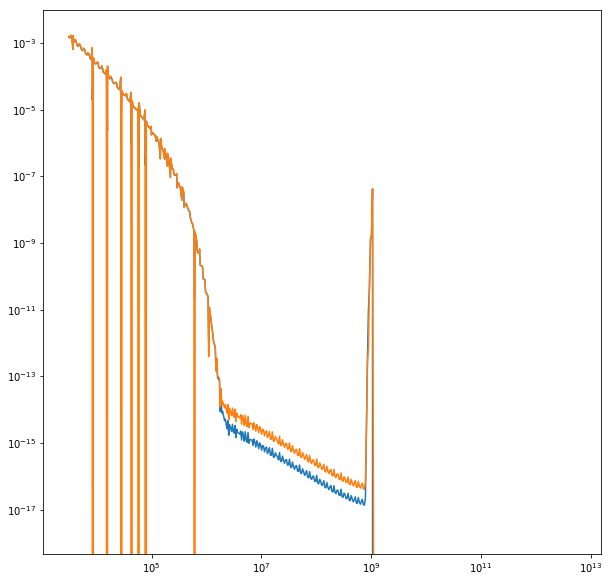

In [22]:
i=2
j=4
print(photon_spectra[i].rs)
print(file_spectra[j].rs)

ax = plt.subplot(1,1,1)
plt.plot(photon_spectra.eng, photon_spectra[i].dNdE)
# plt.plot(photon_spectra.eng, photon_spectra[i+5].dNdE)
# plt.plot(file_spectra.eng, file_spectra[j-2].dNdE)
# plt.plot(file_spectra[j-1].eng, file_spectra[j-1].dNdE)
plt.plot(file_spectra[j].eng, file_spectra[j].dNdE)
ax.set_xscale('log')
ax.set_yscale('log')
# b = file_spectra.plot(2)
# axb = b.add_subplot(1,1,1)
# axb.set_xscale('log')
# axb.set_yscale('log')


In [17]:
np.set_printoptions(threshold=np.nan)
utils.compare_arr([photon_spectra[i].dNdE, 
                   file_spectra[j].dNdE, 
                   ])

[[  7.54777529e-04   7.77417825e-04]
 [  7.03327599e-04   7.24424851e-04]
 [  8.37667015e-04   8.62793968e-04]
 [  7.44010068e-04   7.66327665e-04]
 [  3.16393957e-04   3.25884626e-04]
 [  8.15485491e-04   8.39947106e-04]
 [  5.25877205e-04   5.41651609e-04]
 [  6.24855886e-04   6.43599249e-04]
 [  5.54669811e-04   5.71307922e-04]
 [  4.21238690e-04   4.33874313e-04]
 [  3.92251795e-04   4.04017907e-04]
 [  4.65161731e-04   4.79114878e-04]
 [  4.12294750e-04   4.24662086e-04]
 [  3.13463792e-04   3.22866545e-04]
 [  2.91745742e-04   3.00497035e-04]
 [  3.42928719e-04   3.53215340e-04]
 [  3.07563979e-04   3.16789760e-04]
 [  2.32532496e-04   2.39507612e-04]
 [  2.16296238e-04   2.22784328e-04]
 [  2.49934600e-04   2.57431718e-04]
 [  2.30418069e-04   2.37329766e-04]
 [  1.71883656e-04   1.77039538e-04]
 [  1.59774745e-04   1.64567402e-04]
 [  3.55014249e-04   3.65663356e-04]
 [  0.00000000e+00   0.00000000e+00]
 [  1.75867015e-04   1.81142389e-04]
 [  1.26460571e-04   1.30253922e-04]
 

0